## Applications - Time Series Prediction

## LSTM

## Imports

In [17]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, LSTM
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.6.5-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.14 | packaged by conda-forge | (main, Nov 21 2022, 13:20:59) 
[Clang 14.0.6 ]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is available


## Read data

In [18]:
csv_file_path = 'AXISBANK_with_indicators_.csv'

df_AXISBANK = pd.read_csv(csv_file_path)
df_AXISBANK

,date,open,high,low,close,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
0,2015-02-02 14:30:00+05:30,614.05,614.10,611.40,611.45,93389,613.92,612.765,608.963333,604.7025,...,29.288305,0.000000,8.496577e-01,56.988461,-24.277457,2.824265,2.70,612.316667,31.515298,0.758112
1,2015-02-02 14:35:00+05:30,611.45,611.90,609.10,610.85,167555,612.83,613.000,610.213333,605.6450,...,16.754954,0.000000,4.248289e-01,47.610166,-35.475578,2.822531,2.80,610.616667,30.943413,0.714789
2,2015-02-02 14:40:00+05:30,610.80,611.75,610.40,610.75,159844,612.21,613.290,610.996667,606.5825,...,15.781700,0.000000,3.315866e-14,42.053753,-45.307443,2.717351,1.35,610.966667,30.534145,1.093591
3,2015-02-02 14:45:00+05:30,610.75,612.00,610.10,611.00,59073,611.61,613.505,611.576667,607.5325,...,24.832959,4.144354,1.381451e+00,41.463744,-53.571429,2.658968,1.90,611.033333,30.609989,1.125454
4,2015-02-02 14:50:00+05:30,611.00,612.50,610.60,612.00,62210,611.21,613.135,611.896667,608.5375,...,36.735294,100.000000,3.471478e+01,45.844448,-48.936170,2.604756,1.90,611.700000,31.164563,1.144591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130344,2022-02-18 15:05:00+05:30,787.75,788.00,786.45,787.10,97135,786.37,785.935,786.523333,787.2675,...,56.145210,79.261810,5.975394e+01,52.212669,-48.739496,1.637444,1.55,787.183333,25.002182,0.011385
130345,2022-02-18 15:10:00+05:30,787.15,787.85,786.40,787.20,98721,786.62,786.195,786.356667,787.1400,...,56.380366,84.350488,8.787077e+01,52.953355,-40.000000,1.624055,1.45,787.150000,24.277293,0.038598
130346,2022-02-18 15:15:00+05:30,787.20,787.65,786.10,787.00,165982,786.89,786.330,786.270000,787.0375,...,50.818027,73.084059,7.889879e+01,50.842869,-41.584158,1.618765,1.55,786.916667,23.649002,0.056849
130347,2022-02-18 15:20:00+05:30,786.90,788.00,786.50,788.00,134733,787.36,786.605,786.220000,786.9850,...,56.450170,100.000000,8.581152e+01,55.692888,-21.782178,1.610282,1.50,787.500000,23.000130,0.059598


Cut for overfit on train

In [19]:
df_AXISBANK = df_AXISBANK[120034:]
df_AXISBANK

,date,open,high,low,close,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
120034,2021-08-02 13:10:00+05:30,722.50,722.95,721.95,722.1,29728,722.39,722.125,721.853333,721.8350,...,44.000000,0.000000,49.170488,36.747046,-47.619048,1.000687,1.00,722.333333,26.466896,0.445373
120035,2021-08-02 13:15:00+05:30,722.15,722.70,722.10,722.7,21580,722.46,722.225,721.913333,721.8375,...,48.424242,95.937947,47.816470,44.272358,-19.047619,0.972067,0.60,722.500000,26.985521,0.374203
120036,2021-08-02 13:20:00+05:30,722.70,722.90,722.10,722.5,26848,722.48,722.370,721.993333,721.8550,...,51.471861,57.874597,51.270848,45.659878,-28.571429,0.959776,0.80,722.500000,26.941670,-0.312891
120037,2021-08-02 13:25:00+05:30,722.55,722.70,719.20,720.8,108056,722.11,722.215,721.960000,721.7950,...,59.027417,0.000000,51.270848,47.826341,-58.974359,1.141221,3.50,720.900000,26.633383,3.137922
120038,2021-08-02 13:30:00+05:30,720.85,721.00,720.45,721.0,34887,721.82,722.110,721.960000,721.7800,...,49.269841,11.600988,23.158528,49.998624,-53.846154,1.098991,0.55,720.816667,26.207468,-1.009256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130344,2022-02-18 15:05:00+05:30,787.75,788.00,786.45,787.1,97135,786.37,785.935,786.523333,787.2675,...,56.145210,79.261810,59.753937,52.212669,-48.739496,1.637444,1.55,787.183333,25.002182,0.011385
130345,2022-02-18 15:10:00+05:30,787.15,787.85,786.40,787.2,98721,786.62,786.195,786.356667,787.1400,...,56.380366,84.350488,87.870766,52.953355,-40.000000,1.624055,1.45,787.150000,24.277293,0.038598
130346,2022-02-18 15:15:00+05:30,787.20,787.65,786.10,787.0,165982,786.89,786.330,786.270000,787.0375,...,50.818027,73.084059,78.898786,50.842869,-41.584158,1.618765,1.55,786.916667,23.649002,0.056849
130347,2022-02-18 15:20:00+05:30,786.90,788.00,786.50,788.0,134733,787.36,786.605,786.220000,786.9850,...,56.450170,100.000000,85.811516,55.692888,-21.782178,1.610282,1.50,787.500000,23.000130,0.059598


Each day is 75 time units
### Parameters:

In [21]:
df = df_AXISBANK

df['datetime'] = pd.to_datetime(df['date'])
df['date'] = df['datetime'].dt.date
time_units_per_day = df.groupby('date').size()

print(time_units_per_day)

date
2021-08-02    28
2021-08-03    75
2021-08-04    75
2021-08-05    75
2021-08-06    75
              ..
2022-02-14    75
2022-02-15    75
2022-02-16    75
2022-02-17    75
2022-02-18    75
Length: 139, dtype: int64


/var/folders/yv/vvxb5lx13vz_0jj4k_xqtcnm0000gn/T/ipykernel_5468/876623339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'])
/var/folders/yv/vvxb5lx13vz_0jj4k_xqtcnm0000gn/T/ipykernel_5468/876623339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


In [22]:
mum_units_in_day = 75
num_days_test = 5

## Pre Process

In [23]:
long_version = True

Select column subset

In [24]:
if long_version:
    # Selecting the required columns
    selected_columns = [
        'open', 'high', 'low', 'close', 'volume', 'sma5', 'fastd', 'ATR', 'middleband', 'ROC5', 'BETA'
    ]

    # Subsetting the DataFrame
    df_AXISBANK = df_AXISBANK[selected_columns]
    df_AXISBANK
else:
    # Selecting the required columns
    selected_columns = [
        'open', 'close', 'volume'
    ]

    # Subsetting the DataFrame
    df_AXISBANK = df_AXISBANK[selected_columns]
    df_AXISBANK

df_AXISBANK

,open,high,low,close,volume,sma5,fastd,ATR,middleband,ROC5,BETA
120034,722.50,722.95,721.95,722.1,29728,722.39,44.000000,1.000687,722.39,-0.006924,0.445373
120035,722.15,722.70,722.10,722.7,21580,722.46,48.424242,0.972067,722.46,0.048453,0.374203
120036,722.70,722.90,722.10,722.5,26848,722.48,51.471861,0.959776,722.48,0.013843,-0.312891
120037,722.55,722.70,719.20,720.8,108056,722.11,59.027417,1.141221,722.11,-0.256002,3.137922
120038,720.85,721.00,720.45,721.0,34887,721.82,49.269841,1.098991,721.82,-0.200706,-1.009256
...,...,...,...,...,...,...,...,...,...,...,...
130344,787.75,788.00,786.45,787.1,97135,786.37,56.145210,1.637444,786.37,0.114475,0.011385
130345,787.15,787.85,786.40,787.2,98721,786.62,56.380366,1.624055,786.62,0.159043,0.038598
130346,787.20,787.65,786.10,787.0,165982,786.89,50.818027,1.618765,786.89,0.171832,0.056849
130347,786.90,788.00,786.50,788.0,134733,787.36,56.450170,1.610282,787.36,0.299115,0.059598


Normalize

In [25]:
# In this case this is identical for long and not long, but left as is in case we want to add additional columns back that we do not
# want to scale in long version
if long_version:
    # Initialize scaler for all features except 'close'
    scaler = MinMaxScaler()
    # Fit and transform features, omitting 'close'
    df_scaled = pd.DataFrame(scaler.fit_transform(df_AXISBANK.drop(columns=['close'])), columns=df_AXISBANK.drop(columns=['close']).columns)

    # Initialize a scaler for 'close' (this is so we can reverse this only)
    close_scaler = MinMaxScaler()
    # Fit this scaler to the 'close' column
    df_scaled['close'] = close_scaler.fit_transform(df_AXISBANK[['close']])
else:
    # Initialize scaler for all features except 'BETA' and 'close'
    scaler = MinMaxScaler()
    # Fit and transform features, omitting 'BETA' and 'close'
    df_scaled = pd.DataFrame(scaler.fit_transform(df_AXISBANK.drop(columns=['close'])), columns=df_AXISBANK.drop(columns=['close']).columns)

    # Initialize a separate scaler for 'close'
    close_scaler = MinMaxScaler()
    # Fit this scaler to the 'close' column
    df_scaled['close'] = close_scaler.fit_transform(df_AXISBANK[['close']])


In [26]:
df_scaled

,open,high,low,volume,sma5,fastd,ATR,middleband,ROC5,BETA,close
0,0.342450,0.334181,0.350474,0.005772,0.341711,0.440000,0.059194,0.341711,0.539085,0.191062,0.335032
1,0.340841,0.333025,0.351185,0.003489,0.342045,0.484242,0.054130,0.342045,0.545670,0.189705,0.337813
2,0.343369,0.333950,0.351185,0.004965,0.342140,0.514719,0.051955,0.342140,0.541555,0.176610,0.336886
3,0.342680,0.333025,0.337441,0.027721,0.340376,0.590274,0.084060,0.340376,0.509466,0.242377,0.329008
4,0.334866,0.325162,0.343365,0.007217,0.338993,0.492698,0.076588,0.338993,0.516042,0.163339,0.329935
...,...,...,...,...,...,...,...,...,...,...,...
10310,0.642381,0.635060,0.656161,0.024660,0.646843,0.561452,0.171863,0.646843,0.553521,0.182791,0.636237
10311,0.639623,0.634366,0.655924,0.025105,0.648035,0.563804,0.169494,0.648035,0.558821,0.183309,0.636701
10312,0.639853,0.633441,0.654502,0.043952,0.649323,0.508180,0.168558,0.649323,0.560342,0.183657,0.635774
10313,0.638474,0.635060,0.656398,0.035196,0.651564,0.564502,0.167057,0.651564,0.575477,0.183709,0.640408


Create sequences for models

In [27]:
def create_sequences(df, seq_len):
    xs = []
    ys_binary = []
    ys_continuous = []
    for i in range(len(df) - seq_len):
        x = df.iloc[i:(i + seq_len)].values
        y = (df.iloc[i + seq_len]['close'] > df.iloc[i + seq_len - 1]['close']).astype(int)
        ys_binary.append(y)
        ys_continuous.append(df.iloc[i + seq_len]['close'])
        xs.append(x)
    return np.array(xs), np.array(ys_binary), np.array(ys_continuous)

In [28]:
seq_len = 32  # HyperParam can be played with
X, y_binary, y_continuous = create_sequences(df_scaled, seq_len)

Split to train test

In [29]:
test_size = mum_units_in_day * num_days_test
split_idx = int(len(X) - test_size)

# Manual split using the calculated index to note temporal data
X_train = X[:split_idx]
y_train_continuous = y_continuous[:split_idx]
y_train_binary = y_binary[:split_idx]

y_test_binary = y_binary[split_idx:]
X_test = X[split_idx:]
y_test_continuous = y_continuous[split_idx:]

## Models

In [30]:
def lstm_encoder(inputs, units):
    x = LSTM(units, return_sequences=True)(inputs)
    return x

In [31]:
def build_lstm_model(input_shape, num_layers, units, output_units, activation='linear'):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = lstm_encoder(x, units)
    x = GlobalAveragePooling1D()(x)
    x = Dense(100, activation="relu")(x)
    outputs = Dense(output_units, activation=activation)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Create Model

In [32]:
num_features = X_train.shape[2]
model_continuous = build_lstm_model(input_shape=(seq_len, num_features), num_layers=4, units=256, output_units=1, activation='linear')

Metal device set to: Apple M1 Pro


2024-06-06 19:02:20.867640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-06 19:02:20.868046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Compile Model

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_continuous.compile(optimizer=optimizer, loss='mean_squared_error')

Fit Model

In [72]:
# Fit the continuous model
history_continuous = model_continuous.fit(
    X_train, y_train_continuous,
    #validation_split=0.1,
    epochs=1024,
    batch_size=32
    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/1024
310/310 [==============================] - 15s 48ms/step - loss: 5.0089e-05
Epoch 2/1024
310/310 [==============================] - 15s 47ms/step - loss: 5.0088e-05
Epoch 3/1024
310/310 [==============================] - 15s 49ms/step - loss: 4.9355e-05
Epoch 4/1024
310/310 [==============================] - 15s 49ms/step - loss: 5.0266e-05
Epoch 5/1024
310/310 [==============================] - 15s 49ms/step - loss: 5.1391e-05
Epoch 6/1024
310/310 [==============================] - 14s 46ms/step - loss: 4.8540e-05
Epoch 7/1024
310/310 [==============================] - 14s 45ms/step - loss: 4.9154e-05
Epoch 8/1024
310/310 [==============================] - 14s 46ms/step - loss: 4.9174e-05
Epoch 9/1024
310/310 [==============================] - 15s 49ms/step - loss: 4.9504e-05
Epoch 10/1024
310/310 [==============================] - 16s 50ms/step - loss: 4.9406e-05
Epoch 11/1024
310/310 [==============================] - 15s 49ms/step - loss: 5.0229e-05
Epoch 12/1024
310/3

310/310 [==============================] - 12s 38ms/step - loss: 4.9013e-05
Epoch 93/1024
310/310 [==============================] - 13s 43ms/step - loss: 4.7916e-05
Epoch 94/1024
310/310 [==============================] - 13s 43ms/step - loss: 4.8201e-05
Epoch 95/1024
310/310 [==============================] - 14s 44ms/step - loss: 5.0540e-05
Epoch 96/1024
310/310 [==============================] - 14s 44ms/step - loss: 4.9185e-05
Epoch 97/1024
310/310 [==============================] - 14s 44ms/step - loss: 4.8388e-05
Epoch 98/1024
310/310 [==============================] - 13s 43ms/step - loss: 4.8956e-05
Epoch 99/1024
310/310 [==============================] - 13s 43ms/step - loss: 4.7721e-05
Epoch 100/1024
310/310 [==============================] - 14s 46ms/step - loss: 4.9600e-05
Epoch 101/1024
310/310 [==============================] - 16s 51ms/step - loss: 4.9557e-05
Epoch 102/1024
310/310 [==============================] - 15s 49ms/step - loss: 4.9699e-05
Epoch 103/1024
310/31

310/310 [==============================] - 18s 59ms/step - loss: 4.7726e-05
Epoch 273/1024
310/310 [==============================] - 19s 60ms/step - loss: 4.7289e-05
Epoch 274/1024
310/310 [==============================] - 18s 58ms/step - loss: 4.8617e-05
Epoch 275/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.7178e-05
Epoch 276/1024
310/310 [==============================] - 19s 60ms/step - loss: 4.7678e-05
Epoch 277/1024
310/310 [==============================] - 18s 58ms/step - loss: 4.5623e-05
Epoch 278/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.6042e-05
Epoch 279/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.8026e-05
Epoch 280/1024
310/310 [==============================] - 19s 60ms/step - loss: 4.6699e-05
Epoch 281/1024
310/310 [==============================] - 19s 60ms/step - loss: 4.7501e-05
Epoch 282/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.5795e-05
Epoch 283/1024

310/310 [==============================] - 19s 60ms/step - loss: 5.0470e-05
Epoch 453/1024
310/310 [==============================] - 18s 57ms/step - loss: 4.3918e-05
Epoch 454/1024
310/310 [==============================] - 18s 58ms/step - loss: 4.6042e-05
Epoch 455/1024
310/310 [==============================] - 18s 57ms/step - loss: 4.6304e-05
Epoch 456/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.5235e-05
Epoch 457/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.6343e-05
Epoch 458/1024
310/310 [==============================] - 18s 58ms/step - loss: 4.5126e-05
Epoch 459/1024
310/310 [==============================] - 18s 58ms/step - loss: 4.5197e-05
Epoch 460/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.5411e-05
Epoch 461/1024
310/310 [==============================] - 18s 59ms/step - loss: 4.5440e-05
Epoch 462/1024
310/310 [==============================] - 18s 58ms/step - loss: 4.4745e-05
Epoch 463/1024

310/310 [==============================] - 15s 48ms/step - loss: 4.2432e-05
Epoch 633/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.3136e-05
Epoch 634/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.3051e-05
Epoch 635/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.4018e-05
Epoch 636/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.2709e-05
Epoch 637/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.5250e-05
Epoch 638/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.3873e-05
Epoch 639/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.3540e-05
Epoch 640/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.2755e-05
Epoch 641/1024
310/310 [==============================] - 15s 49ms/step - loss: 4.3016e-05
Epoch 642/1024
310/310 [==============================] - 15s 49ms/step - loss: 4.2987e-05
Epoch 643/1024

310/310 [==============================] - 15s 50ms/step - loss: 4.1576e-05
Epoch 813/1024
310/310 [==============================] - 16s 50ms/step - loss: 4.0396e-05
Epoch 814/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.2512e-05
Epoch 815/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.0837e-05
Epoch 816/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.1630e-05
Epoch 817/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.1606e-05
Epoch 818/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.1263e-05
Epoch 819/1024
310/310 [==============================] - 15s 47ms/step - loss: 4.1608e-05
Epoch 820/1024
310/310 [==============================] - 15s 47ms/step - loss: 4.1542e-05
Epoch 821/1024
310/310 [==============================] - 15s 48ms/step - loss: 3.9928e-05
Epoch 822/1024
310/310 [==============================] - 15s 48ms/step - loss: 4.0852e-05
Epoch 823/1024

310/310 [==============================] - 15s 48ms/step - loss: 3.9481e-05
Epoch 993/1024
310/310 [==============================] - 15s 48ms/step - loss: 3.9834e-05
Epoch 994/1024
310/310 [==============================] - 15s 48ms/step - loss: 3.9562e-05
Epoch 995/1024
310/310 [==============================] - 16s 50ms/step - loss: 3.8912e-05
Epoch 996/1024
310/310 [==============================] - 16s 51ms/step - loss: 3.9511e-05
Epoch 997/1024
310/310 [==============================] - 16s 51ms/step - loss: 3.9325e-05
Epoch 998/1024
310/310 [==============================] - 15s 48ms/step - loss: 3.8769e-05
Epoch 999/1024
310/310 [==============================] - 15s 49ms/step - loss: 3.8820e-05
Epoch 1000/1024
310/310 [==============================] - 15s 48ms/step - loss: 3.8610e-05
Epoch 1001/1024
310/310 [==============================] - 15s 48ms/step - loss: 3.9370e-05
Epoch 1002/1024
310/310 [==============================] - 15s 48ms/step - loss: 3.9952e-05
Epoch 1003/

Get Predictions

In [114]:
y_pred_continuous = model_continuous.predict(X_test)
# Convert continuous predictions to binary predictions for evaluation
y_pred_binary_from_cont = (y_pred_continuous[:-1] < y_pred_continuous[1:]).astype(int)

12/12 [==============================] - 1s 56ms/step


## Visualizations

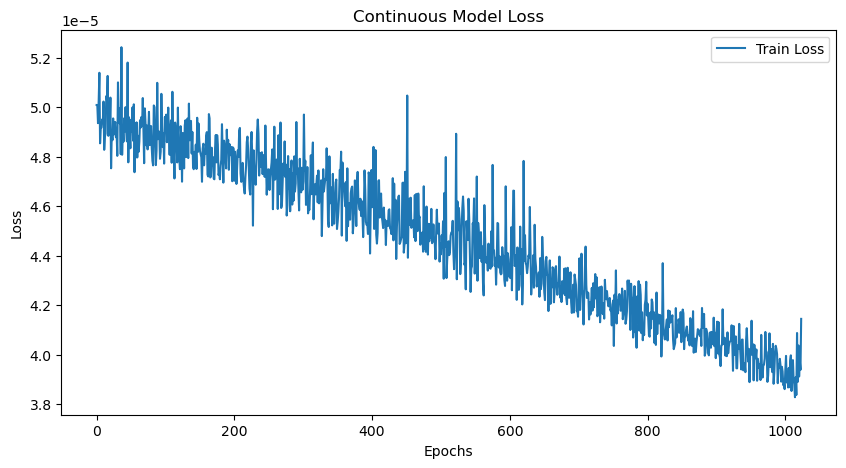

In [116]:
# Plot training loss for the continuous model - this is always a plot of last 1024 epochs (this notebook is run multiple times for longer training on same kernel)
plt.figure(figsize=(10, 5))
plt.plot(history_continuous.history['loss'], label='Train Loss')
plt.title('Continuous Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


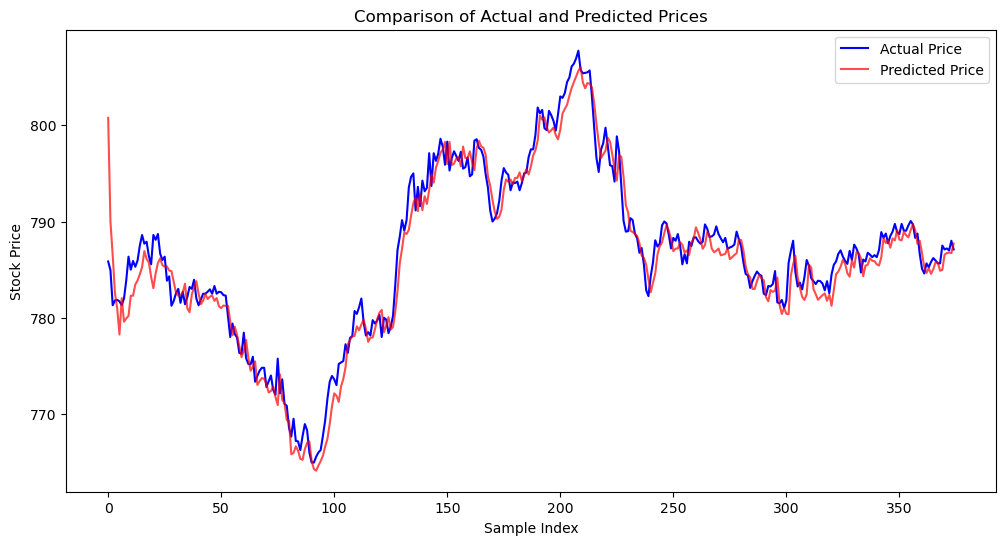

In [117]:
# Rescale the outputs back to the original scale
y_test_continuous_rescaled = close_scaler.inverse_transform(y_test_continuous.reshape(-1, 1))
y_pred_continuous_rescaled = close_scaler.inverse_transform(y_pred_continuous.reshape(-1, 1))

# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_test_continuous_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Trading demo

In [118]:
init_amount = 10000

In [123]:
def continuous_trading_strategy_LSTM(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    total_minutes = (len(y_pred_continuous_rescaled) - 1) * 5  # Each time unit is 5 minutes

    for i in range(len(y_pred_continuous_rescaled) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        current_prediction = y_pred_continuous_rescaled[i][0]
        next_prediction = y_pred_continuous_rescaled[i + 1][0]

        if next_prediction > current_price:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1  # Buy one unit
                current_balance -= current_price  # Subtract the cost of one unit from the balance
                num_buys += 1
            else:
                continue
        elif next_prediction < current_price:  # Predicted to go down
            if stock_units > 0:
                current_balance += stock_units * current_price  # Sell all units
                stock_units = 0
                num_sells += 1
                
        

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100
    
    trading_hours = total_minutes / 60  # Convert total trading minutes to hours

    # Baseline scenario: Buy at the first and sell at the last price
    baseline_first_price = y_test_continuous_rescaled[0][0]
    baseline_final_price = y_test_continuous_rescaled[-1][0]
    baseline_units = init_amount / baseline_first_price
    baseline_final_balance = baseline_units * baseline_final_price
    baseline_gain_loss_percent = ((baseline_final_balance - init_amount) / init_amount) * 100

    print(f"Initial Amount: {init_amount}")
    print(f"Final Balance: {current_balance: .3f}")
    print(f"Total Transactions: {num_buys + num_sells}")
    print(f"Buys: {num_buys}, Sells: {num_sells}")
    print(f"Trading Duration: {trading_hours:.2f} hours")
    if (num_buys + num_sells) > 0:
        print(f"Trades per hour: {(num_buys + num_sells) / trading_hours}")
        print(f"Mean Gain/Loss Percentage per transaction: {gain_loss_percent/(num_buys + num_sells):.5f}%")
    print(f"Gain/Loss Percentage: {gain_loss_percent:.2f}%")
    print("Baseline Scenario:")
    print(f"Baseline Gain/Loss Percentage: {baseline_gain_loss_percent:.2f}%")


In [124]:
continuous_trading_strategy_LSTM(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled)

Initial Amount: 10000
Final Balance:  10049.500
Total Transactions: 109
Buys: 78, Sells: 31
Trading Duration: 31.17 hours
Trades per hour: 3.497326203208556
Mean Gain/Loss Percentage per transaction: 0.00454%
Gain/Loss Percentage: 0.50%
Baseline Scenario:
Baseline Gain/Loss Percentage: 0.16%


In [125]:
def visualize_trading_strategy_LSTM(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled):
    current_balance = init_amount
    stock_units = 0
    num_buys = 0
    num_sells = 0
    balance_history = [current_balance]
    stock_units_history = [stock_units]
    timestamps = list(range(len(y_pred_continuous_rescaled) + 1))
    buy_points = []
    sell_points = []

    for i in range(len(y_pred_continuous_rescaled) - 1):
        current_price = y_test_continuous_rescaled[i][0]
        current_prediction = y_pred_continuous_rescaled[i][0]
        next_prediction = y_pred_continuous_rescaled[i + 1][0]

        if next_prediction > current_price:  # Predicted to go up
            if current_balance >= current_price:  # Check if there's enough balance to buy one unit
                stock_units += 1  # Buy one unit
                current_balance -= current_price  # Subtract the cost of one unit from the balance
                num_buys += 1
                buy_points.append(i)
        elif next_prediction < current_price:  # Predicted to go down
            if stock_units > 0:
                current_balance += stock_units * current_price  # Sell all units
                stock_units = 0
                num_sells += 1
                sell_points.append(i)
        
        balance_history.append(current_balance + stock_units * current_price)
        stock_units_history.append(stock_units)

    # Sell any remaining stock units at the last known price
    final_price = y_test_continuous_rescaled[-1][0]
    if stock_units > 0:
        current_balance += stock_units * final_price
        stock_units = 0
        num_sells += 1
        sell_points.append(len(y_pred_continuous_rescaled) - 1)

    balance_history.append(current_balance + stock_units * current_price)
    stock_units_history.append(stock_units)

    gain_loss_percent = ((current_balance - init_amount) / init_amount) * 100

    # Plot the stock price
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(timestamps[:-1], [price[0] for price in y_test_continuous_rescaled], label='Actual Price')
    plt.scatter(buy_points, [y_test_continuous_rescaled[i][0] for i in buy_points], color='green', label='Buy', marker='^', s=100)
    plt.scatter(sell_points, [y_test_continuous_rescaled[i][0] for i in sell_points], color='red', label='Sell', marker='v', s=100)
    plt.title('Stock Price and Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

    # Plot the account balance
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, balance_history, label='Balance')
    plt.title('Account Balance Over Time')
    plt.xlabel('Time')
    plt.ylabel('Balance')
    plt.legend()

    # Plot the number of stock units held
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, stock_units_history, label='Stock Units Held')
    plt.title('Stock Units Held Over Time')
    plt.xlabel('Time')
    plt.ylabel('Stock Units')
    plt.legend()

    plt.tight_layout()
    plt.show()


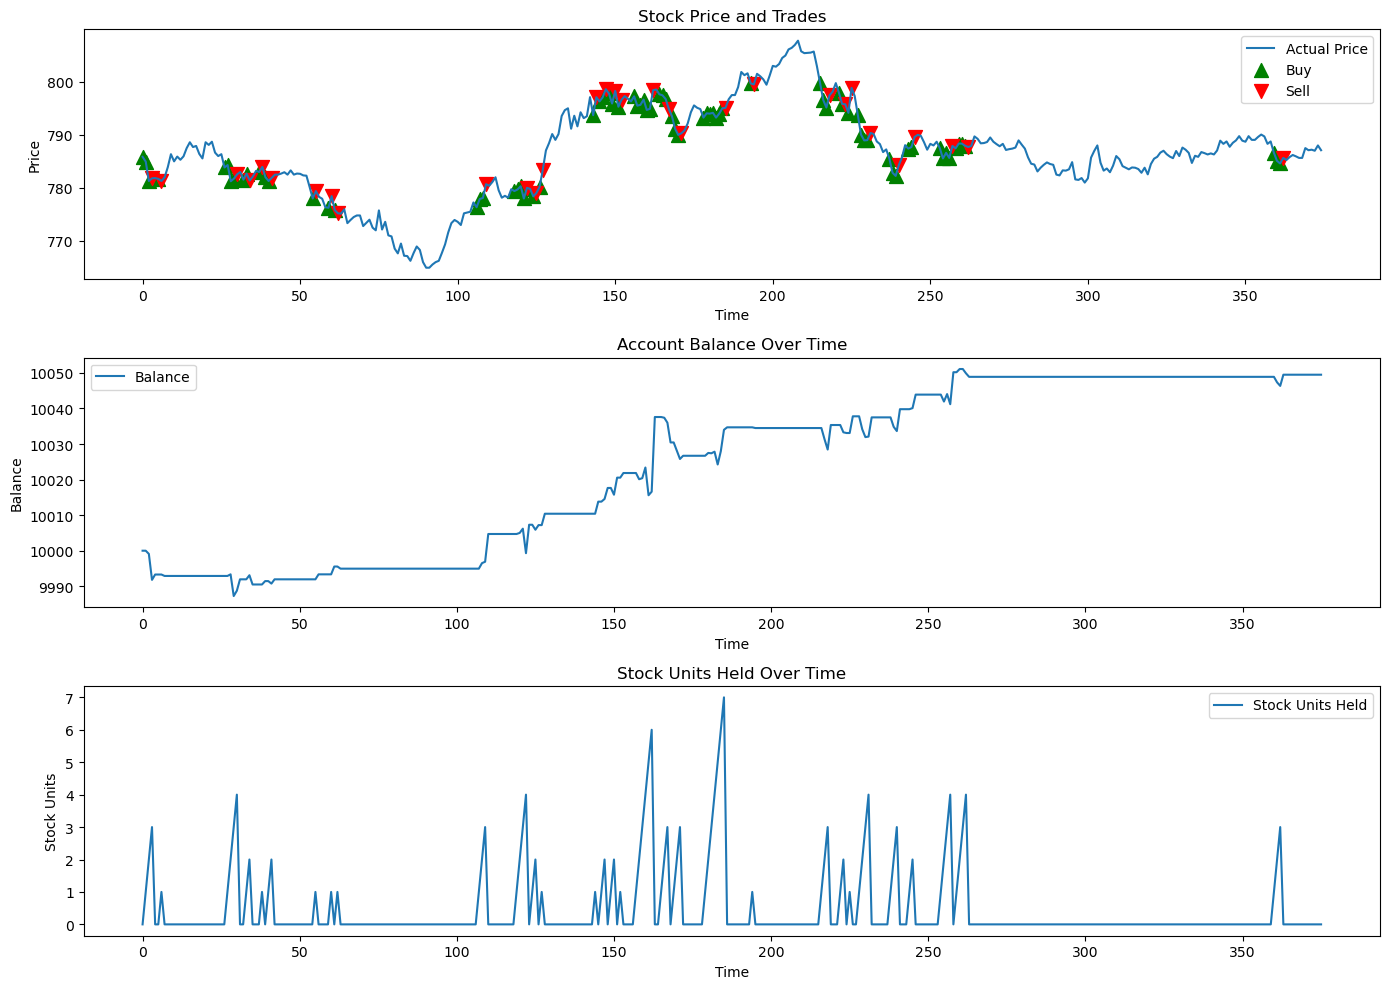

In [126]:
visualize_trading_strategy_LSTM(init_amount, y_test_continuous_rescaled, y_pred_continuous_rescaled)

## Inference on train

In [128]:
y_pred_continuous = model_continuous.predict(X_train)


310/310 [==============================] - 10s 31ms/step


In [107]:
y_pred_binary_from_cont = (y_pred_continuous[:-1] < y_pred_continuous[1:]).astype(int)

# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_train_binary[:-1], y_pred_binary_from_cont))

Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      5107
           1       0.82      0.84      0.83      4800

    accuracy                           0.83      9907
   macro avg       0.83      0.83      0.83      9907
weighted avg       0.83      0.83      0.83      9907



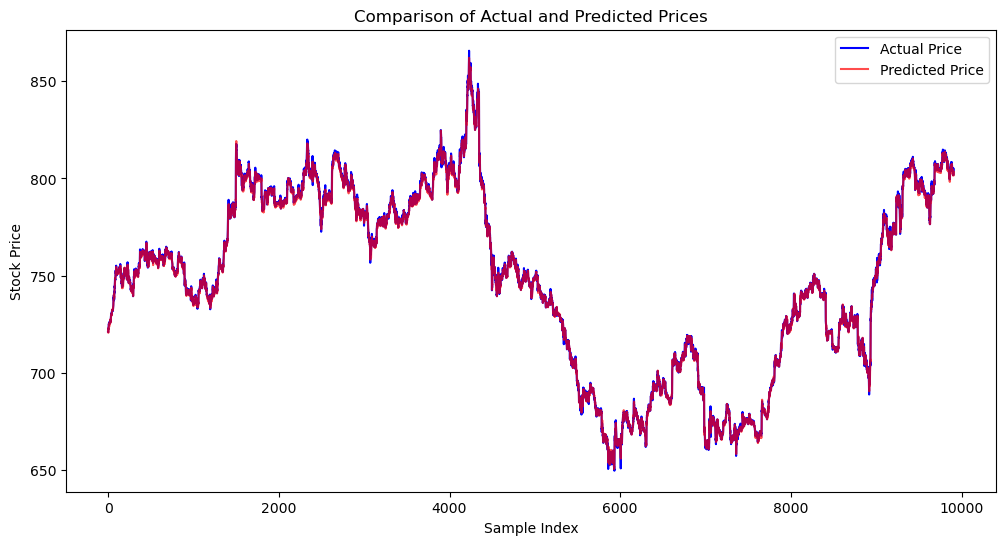

In [129]:
# Train
# Rescale the outputs back to the original scale
y_train_continuous_rescaled = close_scaler.inverse_transform(y_train_continuous.reshape(-1, 1))
y_pred_continuous_rescaled = close_scaler.inverse_transform(y_pred_continuous.reshape(-1, 1))

# Visualization of prediction vs actual for the continuous model
plt.figure(figsize=(12, 6))
plt.plot(y_train_continuous_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [111]:
continuous_trading_strategy_LSTM(init_amount, y_train_continuous_rescaled, y_pred_continuous_rescaled)

Initial Amount: 10000
Final Balance:  14196.500
Total Transactions: 3305
Buys: 2263, Sells: 1042
Trading Duration: 825.58 hours
Trades per hour: 4.003230039366104
Mean Gain/Loss Percentage per transaction: 0.01270%
Gain/Loss Percentage: 41.97%
Baseline Scenario:
Baseline Gain/Loss Percentage: 11.23%


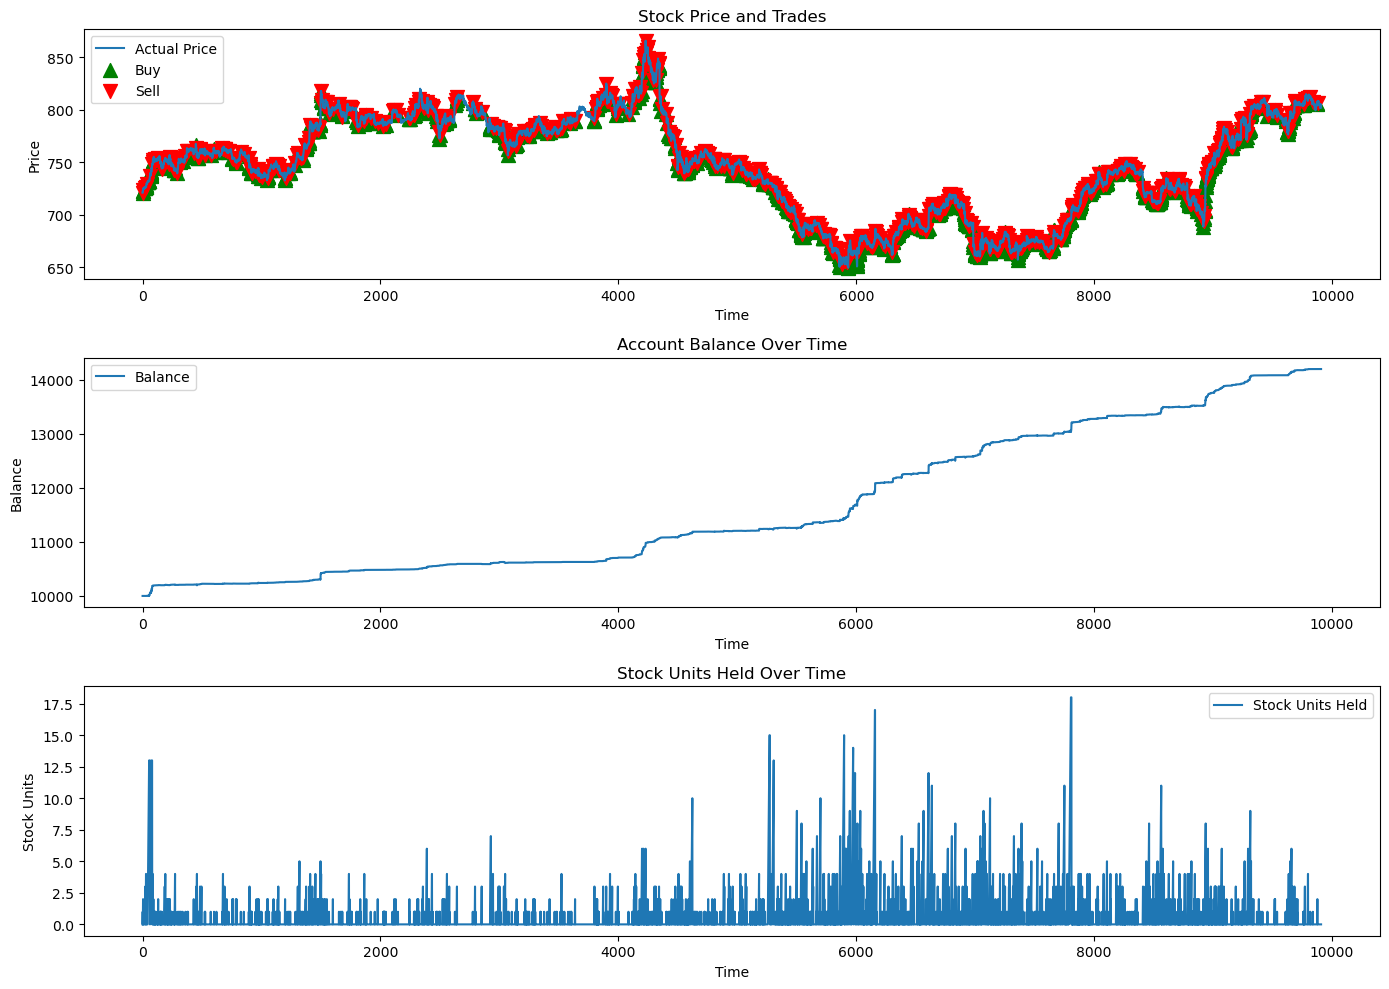

In [130]:
visualize_trading_strategy_LSTM(init_amount, y_train_continuous_rescaled, y_pred_continuous_rescaled)

### shorter timespan

In [132]:
# Evaluate continuous model converted to binary
print("Continuous Model Converted to Binary Classification Report:")
print(classification_report(y_train_binary[:1000], y_pred_binary_from_cont[:1000]))

Continuous Model Converted to Binary Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       521
           1       0.83      0.87      0.85       479

    accuracy                           0.85      1000
   macro avg       0.85      0.86      0.85      1000
weighted avg       0.86      0.85      0.86      1000



In [134]:
continuous_trading_strategy_LSTM(init_amount, y_train_continuous_rescaled[:1000], y_pred_continuous_rescaled[:1000])

Initial Amount: 10000
Final Balance:  10238.800
Total Transactions: 254
Buys: 164, Sells: 90
Trading Duration: 83.25 hours
Trades per hour: 3.051051051051051
Mean Gain/Loss Percentage per transaction: 0.00940%
Gain/Loss Percentage: 2.39%
Baseline Scenario:
Baseline Gain/Loss Percentage: 1.94%


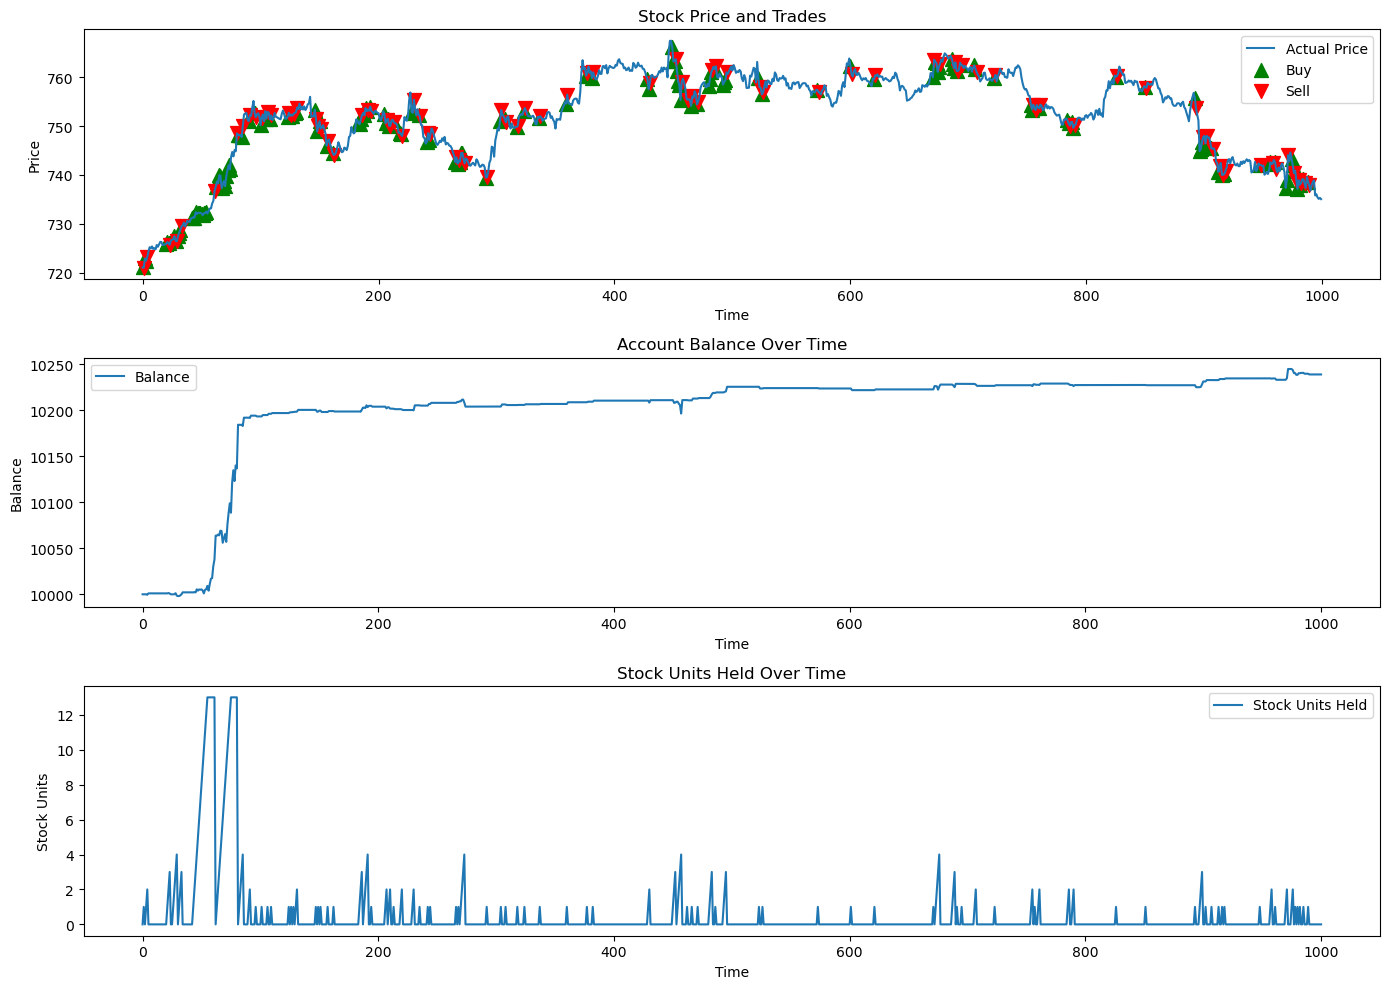

In [135]:
visualize_trading_strategy_LSTM(init_amount, y_train_continuous_rescaled[:1000], y_pred_continuous_rescaled[:1000])

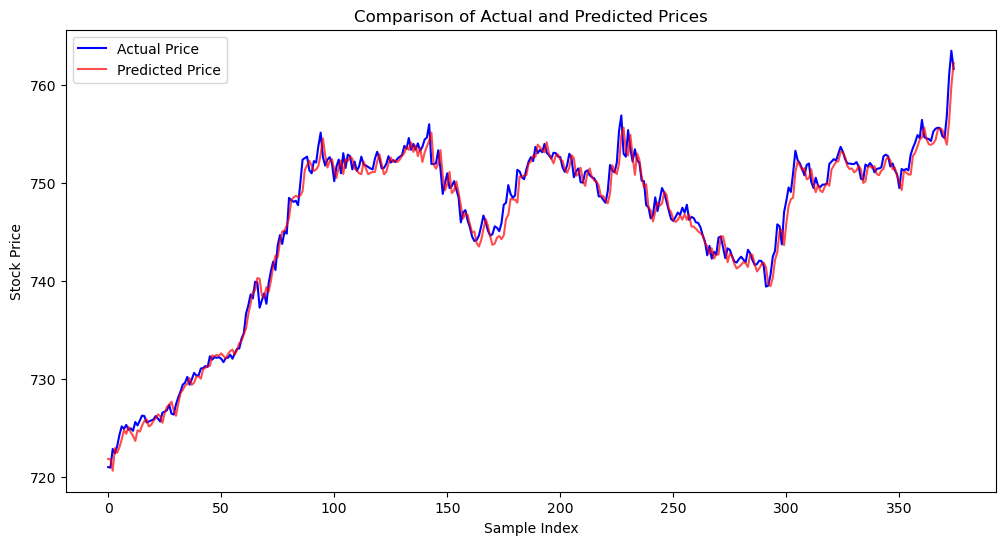

In [136]:
# Visualization of prediction vs actual for the continuous model - 1 week
plt.figure(figsize=(12, 6))
plt.plot(y_train_continuous_rescaled[:375], label='Actual Price', color='blue')
plt.plot(y_pred_continuous_rescaled[:375], label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()